# Predicting Movie Rating based on Tags using Machine Learning and Deep Learning

by Emre Erdem

---
<br> 
### Content ###

#### - Objective
#### - Data Definition 
#### - Load Libraries and Data 
#### - Clean, Process and Examine Data 
#### - Dimensionality Reduction 
##### -- a. PCA 
##### -- b. K-Means Clustering using GLoVe Word Embeddings 
#### - Machine Learning Classification 
#### - Deep Learning using LSTM 
#### - Ensemble Model of Logistic Regression and Deep Learning
#### - Conclusion 

<br> 
<br> 

---

<br> 
<br> 


### Objective ###
Traditionally recommender systems use user-id and movie-id to predict if a user might like a movie using methods such as collaborative filtering. In this project, our aim will be to incorporate other variables as well such as movie genres and tags to classify if a user would rate the movie highly (scoring 4.5 or 5) using machine learning algorithms. 

<br> 


### Data Definition:###
For this purpose I used ratings and tags full datasets from MovieLens: 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Last updated 8/2017.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.



####  - Ratings Data File Structure (ratings.csv) 

All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,movieId,rating,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


####  - Tags Data File Structure (tags.csv) 

All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


####  - Movies Data File Structure (movies.csv)


Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

<br> 
<br>

## Load Libraries and Data

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing
from sklearn import svm
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback

import re
import datetime

# Load datasets
ratings = pd.read_csv('ml-latest/ratings.csv')
print ('Shape of the ratings data frame:', ratings.shape)

tags = pd.read_csv('ml-latest/tags.csv')
print ('Shape of the tags data frame:', tags.shape)

movies = pd.read_csv('ml-latest/movies.csv')
print ('Shape of the movies data frame:', movies.shape)

#Will take
tags = tags.sample(frac=0.2)
ratings = ratings.sample(frac=0.2)

print ('Shape of the sampled ratings data frame:', ratings.shape)
print ('Shape of the sampled tags data frame:', tags.shape)
print ('Shape of the sampled movies data frame:', movies.shape)

('Shape of the ratings data frame:', (26024289, 4))
('Shape of the tags data frame:', (753170, 4))
('Shape of the movies data frame:', (45843, 3))
('Shape of the sampled ratings data frame:', (5204858, 4))
('Shape of the sampled tags data frame:', (150634, 4))
('Shape of the sampled movies data frame:', (45843, 3))


In [2]:
#Print sample ratings data
ratings.head(n=5)

,userId,movieId,rating,timestamp
22932910,238171,6377,4.5,1431544985
20443130,212423,3174,1.0,980827978
4619550,47425,5956,5.0,1225301718
20346742,211396,180,3.0,836236072
9695195,100050,32,3.0,851707132


In [3]:
#Display summary statistics about data
ratings.describe()

,userId,movieId,rating,timestamp
count,8588015.000000,8588015.000000,8588015.000000,8.588015e+06
mean,135050.433178,15841.285320,3.528620,1.171236e+09
std,78170.676171,31071.532756,1.064893,2.052983e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,67175.000000,1073.000000,3.000000,9.905728e+08
50%,135142.000000,2581.000000,3.500000,1.151654e+09
75%,202702.000000,6502.000000,4.000000,1.357555e+09
max,270896.000000,176271.000000,5.000000,1.501828e+09


In [4]:
#Print sample tags data
tags.head(n=5)

,userId,movieId,tag,timestamp
639021,230894,98809,fantasy world,1369170167
619897,222863,115617,superhero,1435948413
1283,741,84395,Demons,1452283189
347615,128855,106920,sad,1433693923
630232,226698,32,mindfuck,1439237185


In [2]:
#Print sample movies data
movies.head(n=5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Drop timestamp data from ratings as the time a movie was rates is not relevant for our purposes. We will keep the timestamp for tags however for two reasons:

Different tags might be associated with a movie by the same user at the same time. Therefore if we split the database randomly, we could create a data leak where it would be easier for the algorithm to predict movie rating.
Instead we will use time to split the data set into training and test datasets. This would be very applicable to a real world scenario where we have past data and we would like to predict ratings in the future for the users. 

In [90]:
ratings = ratings.drop(['timestamp'], axis=1)

We will merge tags and ratings data using inner join as the aim of our project is to determine how accurately we can predict movie rating using tags. Therefore we will not use ratings data without any tags.

In [91]:

data = pd.merge(ratings, tags, how='inner')
print ('Shape of the joint data frame:', data.shape)
print (data.head(n=5))


('Shape of the joint data frame:', (26462, 5))
   userId  movieId  rating              tag   timestamp
0  197574    84772     3.0         roadtrip  1307565165
1  197574    84772     3.0         laidback  1307565160
2   40251    71205     3.5  lesbian subtext  1293733030
3   40251    71205     3.5             sexy  1293733036
4   40251    71205     3.5        Megan Fox  1262848018


# Clean, Process and Examine Data

In [23]:
for column in data.columns:
    print (column, data[column].nunique())

('userId', 6544)
('movieId', 8546)
('rating', 10)
('tag', 13882)
('timestamp', 69229)


We can see that there are 6500 unique users, 8500 movies and 13800 tags. 
There are also 10 available ratings a user can give which makes it possible for us to use classification methods. If there were alot more unique ratings so that target variable is continuous, we could have used regression models. 

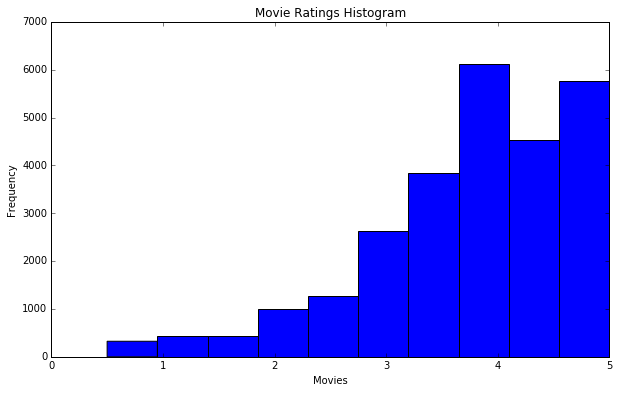

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(data['rating'],10)
plt.xlabel('Movies'); 
plt.ylabel('Frequency')
plt.xlim(0,5)
plt.title('Movie Ratings Histogram')
plt.show()

We can see from the histogram plot that the most frequent movie rating given is 4. 
This also results in an unbalanced target variable, therefore we will need to address this during machine learning. 

Let's visualize tags by average rating to see if get an initial feeling whether tags would be a good predictor variable.



In [5]:
#Compute average ratings by tag
tagratings = pd.pivot_table(data, values=['rating'], columns=['tag'], aggfunc='mean')
tagratings

tag,"""I need a computer.""","""found footage""","""hero"" is murderer",#choices,(s)vcd,*Good* Musicals,007,007 (series),007-like,1,...,yucky,yuen woo-ping,yukon,yuppies,zarzuela,zero gravity,zionism,zombie,zombies,σκατά
rating,4,4.083333,1,5,4.5,3.5,3,3.166667,5,2,...,4,4.5,3.5,1.5,2.5,3.5,3.5,4.166667,3.462264,2


We can see that some tags have higher average ratings than others. We can also see that there are special characters that we can remove to have less number of unique tags and improve our performance. 

In [92]:
#Remove any special characters from tag
#Relabel ratings 
data['rating'] = data['rating'].apply(lambda x: 1 if x > 4 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x))
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
data['tag'] = data['tag'].str.lower()

In [93]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tag'])
sequences = tokenizer.texts_to_sequences(data['tag'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

Found 6619 unique tokens.


In [ ]:
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['timestamp'].astype('datetime64[ns]')

In [95]:
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = data['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()

words = vectorizer.get_feature_names()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(wordvec,columns=words)

('number of words in plot summary: ', 6440)


In [96]:
data.shape

(26462, 5)

# Dimensionality Reduction

## a. PCA

I have decided not to use PCA as the performance was lower than using Clustering Word Embeddings. In order not to crowd the notebook I did not share the results but it is saved in a different notebook. 

In [17]:
#Number of principal components
#d=1000

#Fit PCA model
#pca = PCA(n_components = d)
#pca.fit(pdwordvec)
#pc = pca.components_
#wordvec_reduced = pca.transform(pdwordvec)


In [18]:
#pca.explained_variance_ratio_.sum()

0.79064562200118071

In [19]:
#pdwordvec_reduced = pd.DataFrame(wordvec_reduced)
#pcadata = pd.concat([data, pdwordvec_reduced], axis=1)

## b. K-Means Clustering Words using Glove Embeddings

Load Stanford's global word embeddings as pre-trained model. Since we do not have a lot of text data to create our own embeddings as tags are comprised of few words , it makes sense to use a pre-trained word embedding model.

In [111]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(words), 100))
for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


In [12]:

reduced_data = PCA(n_components=2).fit_transform(pdembedding.T)
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


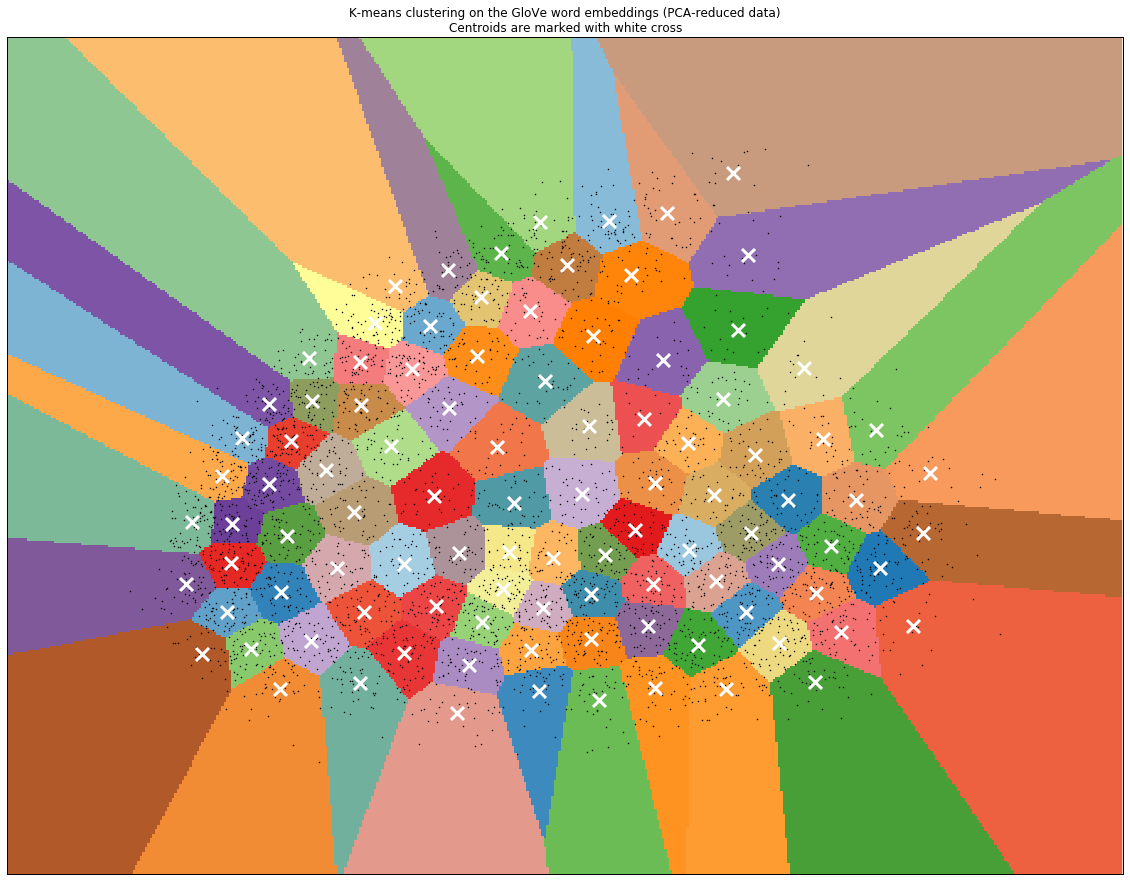

In [13]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

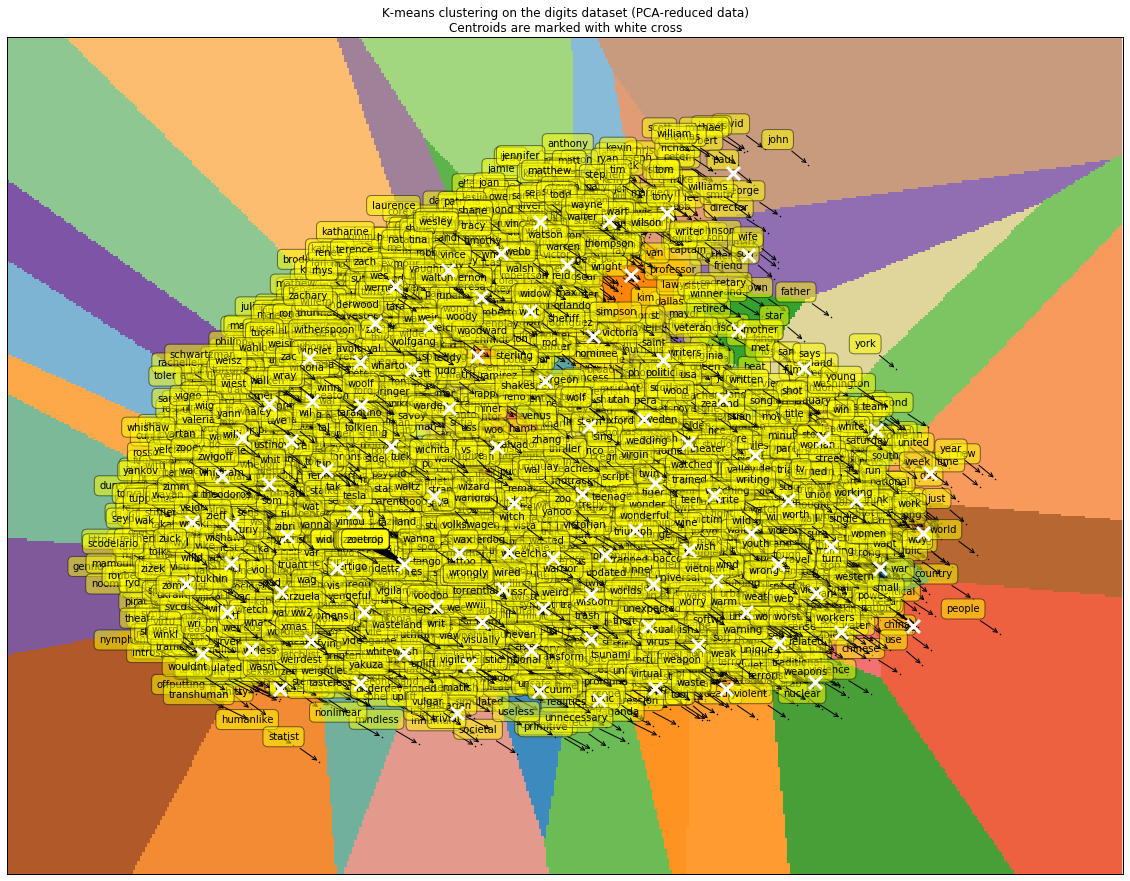

In [16]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Prepare data for Deep Learning

In [98]:
# For deep learning with LSTM, we will only use word sequences
dpdata = pd.concat([data, pdseq], axis=1)

dpdata = dpdata.drop(['tag'], axis=1)
dpdata = dpdata.drop(['userId'], axis=1)
dpdata = dpdata.drop(['movieId'], axis=1)


In [99]:
dpdata.shape

(26462, 30)

### Prepare data for Clustering

In [100]:
#Cluster word embeddings data 
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pdembedding.T)
#Get cluster labels
clusters = kmeans.labels_

#Add columns to data for each cluster
for i in range(max(clusters)+1):
 data[i] = 0

#If word is in data row, label the associated cluster accordingly with 1
for i in range(len(pdwordvec.columns)):
    column = pdwordvec.columns[i]
    index = pdwordvec[column].loc[pdwordvec[column] > 0, ].index
    for ii in range(len(index)):
        data.loc[index[ii],clusters[i]] = 1

Movie genre might also have predictive value as some genres might be liked by a user more than others, or some genres might have higher scores in general than others. A movie might have multiple genres therefore I will use one hot encoding to process movie genre. Then I will join movie genres with our tags and ratings data by movie id. 

In [28]:
data.shape

(26037, 305)

In [101]:
#Drop tag as we will use vectorized words
data = data.drop(['tag'], axis=1)

#Add genres
#Split genre column
genresplit = movies.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genresplit, prefix='genre', columns=['genre']).groupby(level=0).sum()
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)
#Joın data by movieId
genres['movieId'] = genres.index
data = pd.merge(data, genres, on='movieId', how='left')

#Assign variables as categorical using one hot encoding
useridencoding = pd.get_dummies(data['userId'], prefix='userid')
data = data.drop(['userId'], axis=1)
data = pd.concat([data, useridencoding], axis=1)

movieidencoding = pd.get_dummies(data['movieId'], prefix='movieid')
data = data.drop(['movieId'], axis=1)
data = pd.concat([data, movieidencoding], axis=1)

In [102]:
dpdata.shape

(26462, 30)

In [103]:
data.shape

(26462, 9923)

In [32]:
data.head(n=5)

,rating,timestamp,0,1,2,3,4,5,6,7,...,movieid_173499,movieid_173549,movieid_173771,movieid_174055,movieid_174233,movieid_174399,movieid_174505,movieid_174755,movieid_174933,movieid_176095
0,0,2015-07-31 21:27:44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2015-08-01 00:29:28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2015-07-31 21:27:53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2015-07-31 21:27:42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2015-08-01 00:29:18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
data = data.fillna(np.nan)

Our data looks good and ready for modeling!

# Machine Learning Classification Models

In this part we will start to use machine learning algorithms to predict movie ratings.
Our evaluation metric will be accuracy - we could also use other metrics such as mean squared error as well but I chose accuracy as our key metric as it is the easiest to interpret.

In all of our models, we will address the imbalanced target variable problem by using balanced class weights.
 

In order to evaluate the performance of our models we will split the dataset into training and test sets and use test set accuracy as the benchmark to account for overfitting. We will use the data until Q3-2016 as training set and use the remaining 12 months of data as test set. 

In [105]:
train = data[(data['timestamp'] < '2016-08-01') ]
test = data[(data['timestamp'] >= '2016-08-01') ]

print "Number of rows in test data set:", (len(test))
print "Number of rows in training data set:",(len(train))

Number of rows in test data set: 4023
Number of rows in training data set: 22439


12 months of data with 4k cases will definitely provide a good model accuracy measure. 

In [106]:
#remove timestamp as it won't be needed for modeling
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [107]:
#Define target and predictor variables
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

## Baseline Model

In [37]:
baselineaccuracy = float(y_test.value_counts().max())/y_test.value_counts().sum()
print "Accuracy of the baseline model is: ", np.round(baselineaccuracy,2)

Accuracy of the baseline model is:  0.55


## Logistic Regression Model

The first model we will try is logistic regression. 

In [108]:
logreg = LogReg(C = 1, class_weight='balanced')
logreg.fit (x_train, y_train)
y_predlog = logreg.predict_proba(x_test)
R2_log = logreg.score(x_test,y_test) 
print "Accuracy of the test set for log. reg. is: ", np.round(R2_log,2)

Accuracy of the test set for log. reg. is:  0.66


The accuracy of logistic regression model is higher than the baseline model. Let's see if we can increase the performance using different regularization parameters. 

In [109]:
c = [0.0000001,0.00001,0.0001,0.01, 1, 1000, 1000000]

train_acc = []
test_acc = []

for i in c:
    logit = LogReg( C = i, class_weight='balanced')
    logit.fit(x_train, y_train)
    train_acc.append(logit.score(x_train, y_train))
    test_acc.append(logit.score(x_test, y_test))



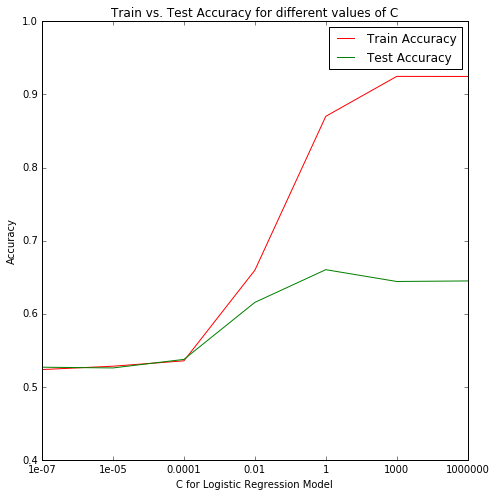

('Accuracy is maximum at C value of', 1, 'and yields accuracy of', 0.66)


In [110]:

#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(7), c)
plt.xlabel('C for Logistic Regression Model')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
plt.title('Train vs. Test Accuracy for different values of C')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at C value of', c[np.argmax(test_acc)],'and yields accuracy of', round(max(test_acc), 2))

## Random Forest

In [41]:
RFC = RandomForestClassifier(class_weight='balanced')
RFC.set_params(n_estimators=100)
RFC.fit(x_train,y_train)
R2_rfc = RFC.score(x_test,y_test) 
print "Accuracy of the test set for random forest is: ", np.round(R2_rfc,2)

Accuracy of the test set for random forest is:  0.64


Random forest performs does not seem to perform better than logistic regression. Let's visualize training and test set accuracy performance based on different levels of depth.

In [25]:
depth = range(2, 55, 5)

train_acc = []
test_acc = []

for i in depth:
    RFC.set_params(n_estimators=100, max_depth=i)
    RFC.fit(x_train, y_train)
    train_acc.append(RFC.score(x_train, y_train))
    test_acc.append(RFC.score(x_test, y_test))


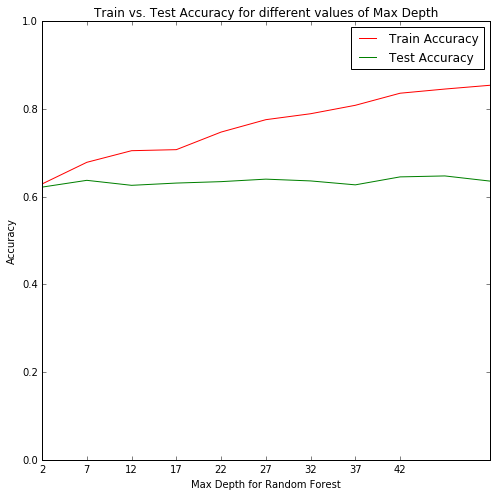

('Accuracy is maximum at max depth value of', 47, 'and yields accuracy of', 0.65)


In [26]:


#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(9), depth)
plt.xlabel('Max Depth for Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Train vs. Test Accuracy for different values of Max Depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at max depth value of', depth[np.argmax(test_acc)],
                'and yields accuracy of', round(max(test_acc), 2))

Another good indicator to look at is feature importance in a random forest model. We can see the effect of tags on the accuracy performance. 

In [42]:
importance = RFC.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC.estimators_], axis=0)

importance['Importance'].sort_values(ascending=False)

userid_178616      0.007798
genre_Drama        0.007333
genre_Thriller     0.006805
genre_Romance      0.006644
userid_257255      0.006533
genre_Comedy       0.006355
userid_78340       0.006058
genre_Adventure    0.006054
genre_Sci-Fi       0.005678
genre_Action       0.005374
genre_Crime        0.005134
userid_167720      0.004816
genre_Fantasy      0.004778
13                 0.004381
genre_Mystery      0.004269
userid_39928       0.004202
userid_138799      0.004177
genre_Horror       0.003733
userid_204457      0.003500
43                 0.003475
userid_111649      0.003418
genre_War          0.003270
22                 0.003222
genre_IMAX         0.003175
274                0.003024
51                 0.003016
199                0.003015
userid_76206       0.003013
userid_151569      0.002887
userid_217520      0.002800
                     ...   
movieid_1663       0.000000
movieid_1646       0.000000
userid_52963       0.000000
userid_52983       0.000000
movieid_1552       0

In [43]:
importance[importance['Importance']==0].count()

Importance    1005
Std           1005
dtype: int64

In [45]:
clus = np.where(clusters==13)
clus = np.array(clus)
clus = pd.DataFrame(clus)
clussamp = clus.T.sample(50)

clus = []
for index, row in clussamp.iterrows():
    clus.append(int(row.values))

for i in clus:
    print words[i]

futuristmoviescom
anticrusades
absentminded
jussan
settingspace
noget
krzyzewska
poisionous
newtonjohn
suspence
snoke
claudemichel
authoredgar
19982012
levant
campbells
ageing
abyme
1010
ummarti2006
chineseamericans
twocolor
oldschoolish
rintense
odonnell
medvesek
karwai
selfindulgent
batshit
gadot
mrbean
yipikaye
myrow
authorharper
dvdram
comparetolast
sakasama
dvdr
prospos
authorhelen
pg13thematic
virtualreality
strre
kubricklike
typemoon
orgiginal
psychothriller
blackandwhite
remakeofla
crueger


We can see that genres and tag clusters are important in prediction. 

In [49]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train,y_train)
R2_nb = NB.score(x_test,y_test) 
print "Accuracy of the test set for Multinomial NB model is: ", np.round(R2_nb,2)

Accuracy of the test set for Multinomial NB model is:  0.65


In [92]:
from sklearn.ensemble import AdaBoostClassifier

AdaB = AdaBoostClassifier()
AdaB.fit(x_train,y_train)
R2_ada = AdaB.score(x_test,y_test) 
print "Accuracy of the test set for AdaBoost model is: ", np.round(R2_ada,2)

Accuracy of the test set for AdaBoost model is:  0.62


In [96]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=20, learning_rate=0.1) 
                
            
clf.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_train, y_train), (x_test, y_test)])  
R2_xgb = clf.score(x_test,y_test) 
print "Accuracy of the test set for XGBoost model is: ", np.round(R2_xgb,2)

[0]	validation_0-error:0.308962	validation_1-error:0.361443
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.309011	validation_1-error:0.360087
[2]	validation_0-error:0.310341	validation_1-error:0.363612
[3]	validation_0-error:0.311721	validation_1-error:0.361171
[4]	validation_0-error:0.312017	validation_1-error:0.360358
[5]	validation_0-error:0.313298	validation_1-error:0.359273
[6]	validation_0-error:0.309356	validation_1-error:0.356291
[7]	validation_0-error:0.308174	validation_1-error:0.357375
[8]	validation_0-error:0.308075	validation_1-error:0.357646
[9]	validation_0-error:0.305513	validation_1-error:0.35602
[10]	validation_0-error:0.303789	validation_1-error:0.359002
[11]	validation_0-error:0.30305	validation_1-error:0.359002
[12]	validation_0-error:0.30305	validation_1-error:0.359273
[13]	validation_0-error:0.30167	validation_1-error:0.357104

## Deep Learning Model using Word Embeddings and LSTM

Neural networks are coveted for their performance with huge amounts of data - suitable for tasks such as image recognition and NLP. I wanted to give it a shot using GloVe embeddings as a layer and LSTM to top it, ending with dense layer with softmax activation. 

In [112]:
train = dpdata[(dpdata['timestamp'] < '2016-08-01') ]
test = dpdata[(dpdata['timestamp'] >= '2016-08-01') ]

print "Number of rows in test data set:", (len(test))
print "Number of rows in training data set:",(len(train))

Number of rows in test data set: 4023
Number of rows in training data set: 22439


In [113]:
#remove timestamp as it won't be needed for modeling
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [114]:
#Define target and predictor variables
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

In [115]:
y_test_matrix = to_categorical(y_test)
y_train_matrix = to_categorical(y_train)
x_train_array = np.array(x_train)
x_test_array = np.array(x_test)

epochs = 20
lrate = 0.01
sgd = SGD(lr=lrate)
early_stopping = EarlyStopping(monitor='acc',patience=2)

model = Sequential()
model.add(Embedding(len(word_index)+1, 100, mask_zero=True, weights=[embedding_matrix],trainable=False))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         662000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 22        
Total params: 666,462
Trainable params: 4,462
Non-trainable params: 662,000
_________________________________________________________________


In [116]:

# Fit the model 
model.fit(x_train_array, y_train_matrix, validation_data=(x_test_array, y_test_matrix), epochs=epochs, batch_size=250, class_weight='balanced', callbacks=[early_stopping, TQDMNotebookCallback()])
# Final evaluation of the model
scores = model.evaluate(x_test_array, y_test_matrix, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 22439 samples, validate on 4023 samples


Epoch 1/20
22439/22439 [==============================] - 9s - loss: 0.6702 - acc: 0.6003 - val_loss: 0.6850 - val_acc: 0.5675

Epoch 2/20
22439/22439 [==============================] - 8s - loss: 0.6540 - acc: 0.6248 - val_loss: 0.6736 - val_acc: 0.5782

Epoch 3/20
22439/22439 [==============================] - 8s - loss: 0.6473 - acc: 0.6307 - val_loss: 0.6684 - val_acc: 0.5866

Epoch 4/20
22439/22439 [==============================] - 8s - loss: 0.6424 - acc: 0.6333 - val_loss: 0.6631 - val_acc: 0.5906

Epoch 5/20
22439/22439 [==============================] - 8s - loss: 0.6391 - acc: 0.6369 - val_loss: 0.6620 - val_acc: 0.5906

Epoch 6/20
22439/22439 [==============================] - 8s - loss: 0.6362 - acc: 0.6379 - val_loss: 0.6592 - val_acc: 0.5963

Epoch 7/20
22439/22439 [==============================] - 8s - loss: 0.6339 - acc: 0.6420 - val_loss: 0.6566 - val_acc: 0.6008

Epoch 8/20
22439/22439 [==============================] - 8s - loss: 0.6321 - acc: 0.6427 - val_loss: 0.6607 - val_acc: 0.5938

Epoch 9/20
22439/22439 [==============================] - 8s - loss: 0.6303 - acc: 0.6430 - val_loss: 0.6589 - val_acc: 0.5943

Epoch 10/20
22439/22439 [==============================] - 8s - loss: 0.6288 - acc: 0.6441 - val_loss: 0.6603 - val_acc: 0.5909

Epoch 11/20
22439/22439 [==============================] - 8s - loss: 0.6274 - acc: 0.6451 - val_loss: 0.6591 - val_acc: 0.5923

Epoch 12/20
22439/22439 [==============================] - 8s - loss: 0.6258 - acc: 0.6463 - val_loss: 0.6618 - val_acc: 0.5918

Epoch 13/20
22439/22439 [==============================] - 9s - loss: 0.6246 - acc: 0.6476 - val_loss: 0.6610 - val_acc: 0.5943

Epoch 14/20
22439/22439 [==============================] - 8s - loss: 0.6231 - acc: 0.6470 - val_loss: 0.6601 - val_acc: 0.5921

Epoch 15/20
22439/22439 [==============================] - 8s - loss: 0.6221 - acc: 0.6479 - val_loss: 0.6630 - val_acc: 0.5923

Epoch 16/20
22439/22439 [==============================] - 8s - loss: 0.6211 - acc: 0.6482 - val_loss: 0.6614 - val_acc: 0.5936

Epoch 17/20
22439/22439 [==============================] - 8s - loss: 0.6198 - acc: 0.6487 - val_loss: 0.6605 - val_acc: 0.5938

Epoch 18/20
22439/22439 [==============================] - 8s - loss: 0.6186 - acc: 0.6510 - val_loss: 0.6626 - val_acc: 0.5933

Epoch 19/20
22439/22439 [==============================] - 8s - loss: 0.6176 - acc: 0.6516 - val_loss: 0.6602 - val_acc: 0.5918

Epoch 20/20
22439/22439 [==============================] - 8s - loss: 0.6164 - acc: 0.6527 - val_loss: 0.6619 - val_acc: 0.5913

In [117]:
y_predlstm = model.predict_proba(x_test_array)

3968/4023 [============================>.] - ETA: 0s 

We can see that deep learning model predicts ratings by user/movie using just the tags with 59% accuracy. Let's see if we can use the deep learning prediction probabilities to improve the performance of our best performing machine learning model: logistic regression.

## Ensemble Model of Deep Learning and Logistic Regression 

In [1]:
#Calculate weighted probabilities 
y_pred = (0.4*y_predlstm + 0.6*y_predlog)

#Predict ratings using the weighted probabilities
y_predensem = np.zeros((len(y_pred)))
for i in range(len(y_pred)):
    if y_pred[i,1] >= 0.5:
        y_predensem[i] = 1

from sklearn.metrics import accuracy_score
print "Accuracy of the test set for Ensemble model is: ", np.round(accuracy_score(y_test, y_predensem),2)   

Accuracy of the test set for Ensemble model is: 0.67


**To summarize, our ensemble model of LSTM deep learning and Logistic Regression model achieves an accuracy of 67%,  11% higher than baseline model.**


## Conclusion

My objective was to predict the rating of a movie by user, using tags attributed to movies by users. As a model to predict whether a user would really like a movie, I grouped 4.5 & 5 scores together versus the others. For this purpose I used full set of the data provided by MovieLens and used an inner join to eliminate any ratings data that did not have any tags. 

After processing and cleaning the data, I used Logistic Regression, Random Forest, Multinomial Naive Bayes,Ada Boost and XGBoost as machine learning algorithms to classify the rating of a movie using userId, movieId, movie genres and tags clustered using GloVe word embeddings. 

The algorithm that had the best classification accuracy was Logistic Regression with 66%. The deep learning model using GloVe word embeddings and LSTM achieved 59% accuracy. The ensemble model that incorporates weighted probabilities of these two models achieved 67% which achieved 11% better accuracy than the baseline model.
